# The Battle of Neighborhoods

# Looking for places in England to start a Bandeoke business

## Table of contents

1. [Introduction: Business Problem](#introduction)

2. [Data](#data)

3. [Methodology](#methodology)

4. [Results](#results)

5. [Discussion](#discuss)

6. [Conclusion](#conclusion)

#### Importing necessary libraries

In [1]:
#pip install geocoder

In [2]:
import numpy as np
import matplotlib as mpl
import json
import pandas as pd
import requests
from bs4 import BeautifulSoup
import geocoder

In [3]:
import matplotlib.pyplot as plt

In [4]:
from builtins import any as b_any

In [5]:
!conda install -c conda-forge geopy --yes 

Solving environment: done

# All requested packages already installed.



In [6]:
from geopy.geocoders import Nominatim

In [7]:
import requests
from pandas.io.json import json_normalize

In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors

In [9]:
from sklearn.cluster import KMeans

In [10]:
#!conda install -c conda-forge folium=0.5.0 --yes
import folium

# 1. Introduction (Business problem) <a name="introduction"></a>

England has been the cradle of diverse artists and bands that have changed the musical scene worlwide. From psychedelic to indie, passing trough progressive and punk, british music has contributed to a great variety of styles and still has a great influence in present mainstream and underground scene. That's why music lovers arrive every year to visit historical music places, go to concerts and enjoy nightlife. 

But, what are the musical preferences of every city in England? This has been drafted by identifying the outstanding artists and bands in every city and finding their musical style.

This would help tourists keen on music to choose the best cities to visit, event promoters to set the city to organize a concert or entrepreunors to select the best place to start a business on music. 

For this project purposes, I'll focus on the point of view of an entrepreunor who is looking for the best place in England to start a Bandeoke business pointed to eighties and nineties popular rock music (post-punk, new wave, alternative and indie). 

To help this entrepreunor, the city where these musical styles are prefered is found. Next, the areas in this city are explored to choose the best to set the location of the Bandeoke.

# 2. Data <a name="data"></a>

## Music data 

As datasets on musical preferences in England weren't found in any data repositories, the musical taste was deducted from raw information about bands musical production available in these sources:

#### List of outstanding music artists and bands from England 

https://en.wikipedia.org/wiki/List_of_music_artists_and_bands_from_England

#### Genres played by bands 

Information available in every band Wikipedia article.

#### Supergenres (musical style)

Classification of genres available in:

https://musicmap.info/

## England population data 

https://worldpopulationreview.com/countries/united-kingdom-population/cities/

## Neighborhoods in Manchester data

#### List of areas in Manchester

https://en.wikipedia.org/wiki/Category:Areas_of_Manchester

#### Manchester areas data

Information available in every Manchester area Wikipedia article.

# 3. Methodology <a name="methodology"></a>

## 3.1. Exploratory data analysis on musical production

To start with, some search was made on datasets or raw information about musical tastes in England by city, with no satisfactory results. However, musical production was considered a good indicator of musical tastes.

Regarding this, raw information about outstanding bands of different popular musical styles in England was found in Wikipedia. These bands were classified by city origin but lacked of information about genres played. To overcome this, every band article available in Wikipedia was explored to get the genres played by the band. 

Once the dataframe of oustanding bands with their genres played was obtained, another mishap was faced. Genres played by bands on the whole, were very diverse, what it made it difficult to classify the style bands. So, a grouping of genres into supergenres was made using the classification achieved in Musicmap. 

Finally, for each band the styles (supergenres) played were identified and a final dataframe of bands, origin city and style played was obtained. The procedure is described onwards.

### a)  Outstanding bands in England by origin city

In the next URL from Wikipedia there is a list of outstanding bands and music artists from England, by origin city:

https://en.wikipedia.org/wiki/List_of_music_artists_and_bands_from_England

Every band is linked to its respective article in Wikipedia, as it's shown in the image below:

<img src="1.png">

Parsing this Wikipedia page:

In [11]:
url_bands='https://en.wikipedia.org/wiki/List_of_music_artists_and_bands_from_England'
wiki_url_bands = requests.get(url_bands).text

In [12]:
soup = BeautifulSoup(wiki_url_bands,'lxml')
#soup.prettify()

After analyzing the soup, the name bands and their articles links are extracted and taken in a dataframe:

In [13]:
bands=soup.select('ul li a')
names = [band.get('title') for band in bands]
refs = [band.get('href') for band in bands]

In [14]:
bands_df=pd.DataFrame()
bands_df['Band']=names
bands_df['Link']=refs
bands_df.dropna(inplace=True)

Similarly, the origin cities are extracted and added to the dataframe:

In [15]:
locations = soup.select('ul li')
cities_aux = [loc.get_text().split('\n') for loc in locations]
cities = [i[0:-1] for i in cities_aux if len(i)>1]
cities = [np.repeat(i[0],len(i)).tolist() for i in cities]
cit=[]
cities=[cit+i for i in cities]
for i in cities:
    cit=cit+i
cities=cit

In [16]:
cities[len(cities):len(bands_df)]=[np.nan for i in range(len(bands_df)-len(cities))]

In [17]:
bands_df['City']=cities

In [18]:
bands_df.dropna(inplace=True)
bands_df.reset_index(inplace=True,drop=True)

In [19]:
bands_df=bands_df.iloc[0:996]

In [20]:
bands_df.replace('/wiki/Hadouken!', '/wiki/Hadouken!_(band)',inplace=True)

In [21]:
bands_df['Link']='https://en.wikipedia.org'+bands_df['Link']

This is the resulting dataframe:

In [22]:
bands_df.head(10)

,Band,Link,City
0,Radiohead,https://en.wikipedia.org/wiki/Radiohead,Abingdon
1,The Troggs,https://en.wikipedia.org/wiki/The_Troggs,Andover
2,Molly Smitten-Downes,https://en.wikipedia.org/wiki/Molly_Smitten-Do...,Anstey
3,The Young Knives,https://en.wikipedia.org/wiki/The_Young_Knives,Ashby-de-la-Zouch
4,Marillion,https://en.wikipedia.org/wiki/Marillion,Aylesbury
5,The Danse Society,https://en.wikipedia.org/wiki/The_Danse_Society,Barnsley
6,Saxon (band),https://en.wikipedia.org/wiki/Saxon_(band),Barnsley
7,The Ward Brothers,https://en.wikipedia.org/wiki/The_Ward_Brothers,Barnsley
8,The Assembly,https://en.wikipedia.org/wiki/The_Assembly,Basildon
9,Depeche Mode,https://en.wikipedia.org/wiki/Depeche_Mode,Basildon


### b) Musical genres played by band

Every band article accesible by its link, has a background information section containing the genres played by the band, as it's shown in the image below:

<img src="3.png">

For pulling band genres from every article, an iteration over every link to parse it and extract 6 genres played at most, has been constructed:

In [23]:
i=0
for link in bands_df['Link']:
    url_band=link
    wiki_band=requests.get(url_band).text
    soup_band = BeautifulSoup(wiki_band,'lxml')
    avail=soup_band.find_all(scope='row')[0:15]
    avail=[data.get_text() for data in avail]
    if ('Genres' in avail):
        data_band=[data.get_text() for data in soup_band.select('tr td')[0:12]]
        indice = [i for i, s in enumerate(data_band) if ((('Rock' in s)|('music' in s)|('rock' in s)|('pop' in s)|('metal' in s)|('punk' in s)|('wave' in s))&~('Wiki' in s))]
        if indice:
            genres=[gen.get('title') for gen in soup_band.select('tr td')[indice[0]].select('a')]
            genres = [x for x in genres if x]
            try: 
                bands_df.loc[i,'Genre1']=genres[0]
            except:
                bands_df.loc[i,'Genre1']=np.nan                
            try: 
                bands_df.loc[i,'Genre2']=genres[1]
            except:
                bands_df.loc[i,'Genre2']=np.nan
            try: 
                bands_df.loc[i,'Genre3']=genres[2]
            except:
                bands_df.loc[i,'Genre3']=np.nan
            try: 
                bands_df.loc[i,'Genre4']=genres[3]
            except:
                bands_df.loc[i,'Genre4']=np.nan
            try: 
                bands_df.loc[i,'Genre5']=genres[4]
            except:
                bands_df.loc[i,'Genre5']=np.nan
            try: 
                bands_df.loc[i,'Genre6']=genres[5]
            except:
                bands_df.loc[i,'Genre6']=np.nan                
        else:
            indice = [i for i, s in enumerate(data_band) if ((', England' in s)|(', UK' in s)|(', United Kingdom' in s))]
            if indice:
                genres=[gen.get('title') for gen in soup_band.select('tr td')[indice[0]+1].select('a')]
                genres = [x for x in genres if x]
                try:   
                    bands_df.loc[i,'Genre1']=genres[0]
                except:
                    bands_df.loc[i,'Genre1']=np.nan
                try:   
                    bands_df.loc[i,'Genre2']=genres[1]
                except:
                    bands_df.loc[i,'Genre2']=np.nan
                try:   
                    bands_df.loc[i,'Genre3']=genres[2]
                except:
                    bands_df.loc[i,'Genre3']=np.nan
                try:   
                    bands_df.loc[i,'Genre4']=genres[3]
                except:
                    bands_df.loc[i,'Genre4']=np.nan 
                try:   
                    bands_df.loc[i,'Genre5']=genres[4]
                except:
                    bands_df.loc[i,'Genre5']=np.nan 
                try:   
                    bands_df.loc[i,'Genre6']=genres[5]
                except:
                    bands_df.loc[i,'Genre6']=np.nan 
    i=i+1

Unfortunately, not every article band has the same structure, so it wasn't possible tho extract the genres for some bands. For this reason, genres played by popular music bands  were entered manually.

In [24]:
bands_df.loc[bands_df[bands_df['Band']=='Briganté'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Tinker Jack'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Editors (band)'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','POST-PUNK REVIVAL','ALTERNATIVE ROCK','DARK WAVE',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Magnetophone'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ART ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Air Traffic'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='White Light Parade'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Levellers (band)'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='New Rhodes'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE POP',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Michael Ball'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['POP ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Mallory Knox'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK','POST-HARDCORE',np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Moose Blood'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['EMO','POP PUNK','EMO POP',np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Struts'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['GLAM ROCK','HARD ROCK','GLAM METAL',np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Lower Than Atlantis'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK','HARD ROCK','POP ROCK','PUNK ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Boyracer'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Jellyfish Kiss'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Hollow Men (band)'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Deep Freeze Mice'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['NEW WAVE',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Delicatessen (band)'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Kasabian'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','ALTERNATIVE ROCK','ELECTRONIC ROCK','SPACE ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Po!'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=="Ruth's Refrigerator"].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['PSYCHEDELIC ROCK','INDIE POP',np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Multi Purpose Chemical'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE METAL',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Breton (band)'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','EXPERIMENTAL ROCK',np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=="Dumpy's Rusty Nuts"].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['NWOBHM',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Eurythmics'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['SYNTHPOP','NEW WAVE','DANCE ROCK',np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Hawkwind'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['SPACE ROCK','HARD ROCK','PROGRESSIVE ROCK','PSYCHEDELIC ROCK','ACID ROCK','PROTO PUNK']
bands_df.loc[bands_df[bands_df['Band']=='James Blunt'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['POP ROCK','FOLK ROCK','FOLK POP','SOFT ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Jimi Hendrix Experience'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['PSYCHEDELIC ROCK','BLUES ROCK','ACID ROCK','HARD ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Kate Nash'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE POP','INDIE ROCK','GARAGE PUNK','GRUNGE',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Killing Joke'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['POST-PUNK','INDUSTRIAL ROCK','GOTHIC ROCK','NEW WAVE','SYNTHPOP','INDUSTRIAL METAL']
bands_df.loc[bands_df[bands_df['Band']=='Klaxons'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','NEW WAVE','POST-PUNK REVIVAL','ELECTRONIC ROCK','DANCE PUNK',np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Lily Allen'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['POP MUSIC','ELECTROPOP',np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Rifles'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The xx'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE POP','INDIE ELECTRONIC','DREAM POP','ELECTRO ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Remiah'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['POWER POP',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Clint Boon Experience'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=="Easterhouse (band)"].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Diagrams'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','INDIE POP',np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=="Maps (band)"].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIETRONICA','DREAM POP','INDIE POP','ELECTROPOP','SYNTHPOP',np.nan]
bands_df.loc[bands_df[bands_df['Band']=="Skyclad (band)"].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['FOLK METAL','THRASH METAL','PROGRESSIVE METAL','POWER METAL',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Curtis Whitefinger'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK','FOLK ROCK','SINGER SONGWRITER',np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Simon Dupree & The Big Sound'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['PSYCHEDELIC ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Amazons'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['ALTERNATIVE ROCK','INDIE ROCK','HARD ROCK','ARENA ROCK',np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='The Cravats'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['PUNK ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Little Man Tate'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['INDIE ROCK',np.nan,np.nan,np.nan,np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='Smokers Die Younger'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['GRUNGE','ART ROCK','INDIE ROCK',"ROCK 'N ROLL",np.nan,np.nan]
bands_df.loc[bands_df[bands_df['Band']=='While She Sleeps'].index.values,['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=['METALCORE',np.nan,np.nan,np.nan,np.nan,np.nan]

Other bands, whose genres played weren't found, but that aren't important for this project (non popular music), were dropped:

In [25]:
bands_df.dropna(subset=['Genre1'],inplace=True)
bands_df.reset_index(drop=True,inplace=True)

Genres are edited to standardize their names:

In [26]:
bands_df['Genre1']=bands_df['Genre1'].str.upper() 
bands_df['Genre2']=bands_df['Genre2'].str.upper() 
bands_df['Genre3']=bands_df['Genre3'].str.upper() 
bands_df['Genre4']=bands_df['Genre4'].str.upper() 
bands_df['Genre5']=bands_df['Genre5'].str.upper() 
bands_df['Genre6']=bands_df['Genre6'].str.upper() 

In [27]:
dict_genres={'2 TONE (MUSIC GENRE)':'2 TONE',
            'AMERICANA (MUSIC)':'AMERICANA',
            'CHAMBER ROCK (PAGE DOES NOT EXIST)':'CHAMBER ROCK',
            'ELECTRO (MUSIC)':'ELECTRO',
             'ROCK AND ROLL':"ROCK 'N ROLL",
            'GARAGE PUNK (FUSION GENRE)':'GARAGE PUNK',
            'GARAGE PUNK ROCK (PAGE DOES NOT EXIST)':'GARAGE PUNK',
            'GEORGIA (U.S. STATE)':'GEORGIA',
            'GLITCH (MUSIC)':'GLITCH',
            'GOSPEL MUSIC':'GOSPEL',
            'GREBO (MUSIC)':'GREBO',
            'GRIME (MUSIC GENRE)':'GRIME',
            'GRIME (MUSIC)':'GRIME',
            'GRIME MUSIC':'GRIME',
            'HEAVY METAL MUSIC':'HEAVY METAL',
            'HIP HOP MUSIC':'HIP HOP',
            'INDUSTRIAL MUSIC':'INDUSTRIAL',
            'JAZZ MUSIC':'JAZZ',
            'LO-FI MUSIC':'LO-FI',
            'MERSEYBEAT':'MERSEY BEAT',
            'NEW WAVE MUSIC':'NEW WAVE',
            'NEW-AGE MUSIC':'NEW-AGE',
            'POP (MUSIC)':'POP MUSIC',
            'POP PUNK MUSIC':'POP PUNK',
            'POST PUNK':'POST-PUNK',
            'POST-INDUSTRIAL MUSIC':'POST-INDUSTRIAL',
            'POST-PUNK REVIVAL':'POST-PUNK REVIVAL',
            'PUNK MUSIC':'PUNK',
            'ROCK (MUSIC)':'ROCK',
            'ROCK MUSIC':'ROCK',
            'SURF PUNK (MUSIC GENRE)':'SURF PUNK',
            'TWO-TONE (MUSIC GENRE)':'2-TONE',
             '2 TONE':'2-TONE',
             'SYNTH-POP':'SYNTHPOP',
             'ADULT CONTEMPORARY MUSIC':'ADULT CONTEMPORARY'
            }

In [28]:
for i in list(dict_genres.keys()):
    bands_df[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']]=bands_df[['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6']].replace(i,dict_genres[i])

Once the genres are obtained, URL links are got rid off:

In [29]:
bands_df.drop(['Link'],axis=1,inplace=True)

In [30]:
bands_df=bands_df.replace(np.nan, '', regex=True)


In [31]:
bands_df.drop([13,90,105,211,248,264,373,382,443,459,473,543,610,661,690,798,809,886],inplace=True)

In [32]:
bands_df.reset_index(inplace=True,drop=True)

This is the resulting dataframe:

In [33]:
bands_df.head(10)

,Band,City,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6
0,Radiohead,Abingdon,ART ROCK,ALTERNATIVE ROCK,ELECTRONICA,EXPERIMENTAL ROCK,,
1,The Troggs,Andover,GARAGE ROCK,POP ROCK,PROTO-PUNK,,,
2,Molly Smitten-Downes,Anstey,FOLK MUSIC,POP MUSIC,,,,
3,The Young Knives,Ashby-de-la-Zouch,POST-PUNK,ART PUNK,EXPERIMENTAL ROCK,INDIE ROCK,,
4,Marillion,Aylesbury,NEO-PROGRESSIVE ROCK,SYMPHONIC ROCK,ART ROCK,POST-PUNK,POP MUSIC,
5,The Danse Society,Barnsley,GOTHIC ROCK,POST-PUNK,DARK WAVE,SYNTHPOP,NEW WAVE,
6,Saxon (band),Barnsley,HEAVY METAL,,,,,
7,The Ward Brothers,Barnsley,POP ROCK,NEW WAVE,,,,
8,Depeche Mode,Basildon,SYNTHPOP,NEW WAVE,DANCE-ROCK,ELECTRONIC ROCK,ALTERNATIVE ROCK,
9,Yazoo (band),Basildon,SYNTHPOP,NEW WAVE,,,,


### c) Grouping the genres into supergenres

In the dataframe above, it's seen that each band plays more than one genre. In some cases, genres played by a band  pertain to differents styles or musical trends. Also, there is a great variety of genres played by all bands as a whole.

In [34]:
bands_df['Genre1'].unique()

array(['ART ROCK', 'GARAGE ROCK', 'FOLK MUSIC', 'POST-PUNK',
       'NEO-PROGRESSIVE ROCK', 'GOTHIC ROCK', 'HEAVY METAL', 'POP ROCK',
       'SYNTHPOP', 'POP MUSIC', 'NEW WAVE', 'ROCK', 'ALTERNATIVE ROCK',
       'INDIE ROCK', 'LEICESTER', 'MATH ROCK', 'BLACKENED DEATH METAL',
       'DEATH METAL', 'PUNK ROCK', 'INDUSTRIAL METAL', 'PROGRESSIVE POP',
       'CONTEMPORARY R&B', 'HARD ROCK', 'PROGRESSIVE ROCK', 'REGGAE',
       'GRINDCORE', 'METALCORE', 'BEAT MUSIC', 'SKA PUNK', 'ROOTS REGGAE',
       'DREAM POP', 'GLAM ROCK', 'EMO POP', 'DOOM METAL',
       'MELODIC HARDCORE', 'ELECTRONICA', 'ALTERNATIVE METAL', 'POP PUNK',
       'HARDCORE PUNK', 'POST-ROCK', 'HOUSE MUSIC', 'INDIE POP',
       'RIOT GRRRL', 'FOLK ROCK', 'INDIE FOLK', 'BRITISH HIP HOP',
       'MOD REVIVAL', 'DRUM AND BASS', 'STREET PUNK', 'TRIP HOP',
       'ELECTRONIC MUSIC', 'DUBSTEP', 'CANTERBURY SCENE',
       'PSYCHEDELIC ROCK', 'EMO', 'POST ROCK', 'RHYTHM AND BLUES',
       'EURODANCE', 'DANCE-POP', '2-TONE', 'SKA

This makes it difficult to analyze the bands in the dataframe. So, it's neccesary tho group genres into sets that represent the musical style. To achieve this, I took into account the classification made in Musicmap:

https://musicmap.info/

In this URL, a great job has made to define supergenres as a super category that groups genres by their affinity:

<img src="4.png">

From Musicmap, I took the genres and supergenres that are related to popular music (in the image, from "INDUSTRIAL & GOTHIC" to "POP MUSIC").

This is the list of genres included in the supergenre "ALTERNATIVE ROCK / INDIE":

In [35]:
sg_alt=['JANGLE POP','INDIE ROCK','NOISE ROCK','DREAM POP',
           'SHOEGAZE','SHOEGAZING','GRUNGE','RAP ROCK', 'RAPCORE', 'FUNK METAL',
           'SKATE PUNK','POP PUNK','MATH ROCK', 'MATHCORE','ALTERNATIVE ROCK','INDIE II',
           'BRITPOP','POST-GRUNGE','POST-ROCK','NEW WAVE REVIVAL']

This is the list of genres included in the supergenre "HARDCORE PUNK":

In [36]:
sg_hcp=['ANARCHO-PUNK', 'CRUST PUNK', 'D-BEAT / DISCORE','HARDCORE PUNK',
           'CROSSOVER THRASH','GRINDCORE','POST-HARDCORE','EMO(CORE) & SCREAMO',
            'MATH ROCK','MATHCORE','METALCORE','NWOAHM',
           'SYNTHCORE', 'CRUNKCORE']

This is the list of genres included in the supergenre "PUNK ROCK / NEW WAVE":

In [37]:
sg_pwv=['PUB ROCK','PROTO PUNK','PROTO-PUNK','PUNK ROCK','ANARCHO-PUNK', 'CRUST PUNK','D-BEAT / DISCORE',
           'SKA REVIVAL', '2-TONE','SKA PUNK','SKACORE','POST-PUNK','NO WAVE','NEW WAVE','ART PUNK',
           'HORROR PUNK','PSYCHOBILLY','SYNTHPOP','NEW ROMANTICS','SKATE PUNK', 'POP PUNK']

This is the list of genres included in the supergenre "GOLDEN AGE / CLASSIC ROCK":

In [38]:
sg_gld=['MERSEY BEAT','FOLK ROCK','BRITISH BLUES', 'BLUES ROCK',
           'PSYCHEDELIC ROCK', 'ACID ROCK','PSYCHEDELIA','HARD ROCK',
            'PROGRESSIVE ROCK', 'ART ROCK','SYMPHONIC ROCK','KRAUTROCK',
           'GLAM ROCK','GLITTER ROCK','SHOCK ROCK','SOUTHERN ROCK','ROCK',
           'HEARTLAND ROCK', 'A.O.R. (ADULT ORIENTED ROCK)','SPACE ROCK']

This is the list of genres included in the supergenre "ROCK 'N' ROLL":

In [39]:
sg_rnr=['SKIFFLE (REVIVAL)',"ROCK 'N ROLL", 'ROCKABILLY','AMERICAN FOLK REVIVAL', 'BRITISH FOLK REVIVAL',
           'SURF ROCK','INSTRUMENTAL ROCK','GARAGE ROCK']

This is the list of genres included in the supergenre "CONTEMPORARY ROCK":

In [40]:
sg_con=['POST-BRITPOP','EMO-ROCK','EMO','GARAGE REVIVAL','POST-PUNK REVIVAL','NU-RAWK',
           'NEW PROG','NU PROG', 'POST PROG','INDIETRONICA', 'CHILLWAVE','NEW WAVE REVIVAL'
           'DANCE-PUNK','NU RAVE','INDIE FOLK','FREAKFOLK','NEW WEIRD AMERICA']

This is the list of genres included in the supergenre "HEAVY METAL":

In [41]:
sg_met=['CLASSIC METAL', 'HEAVY METAL','PROGRESSIVE METAL','POWER METAL','GLAM METAL','HAIR METAL','POP METAL',
           'NWOBHM','THRASH METAL','EXTREME METAL','BLACK I METAL','SPEED METAL',
           'CROSSOVER THRASH','DOOM METAL','DEATH METAL','ALTERNATIVE METAL',
            'STONER METAL', 'SLUDGE METAL','ROCK METAL','SYMPHONIC METAL','GOTHIC METAL',
           'BLACK METAL','NU METAL','RAP METAL','METALCORE','NWOAHM']

This is the list of genres included in the supergenre "INDUSTRIAL & GOTHIC":

In [120]:
sg_inr=['KRAUTROCK','AVANT-GARDE INDUSTRIAL','GOTHIC ROCK','DEATHROCK',
           'ELECTRONIC BODY MUSIC','NOISE MUSIC','DARK AMBIENT', 'DARK INDUSTRIAL',
           'DARK WAVE','COLDWAVE','INDUSTRIAL ROCK','INDUSTRIAL METAL',
           'ELECTRO-INDUSTRIAL','AGGREPPO','FUTUREPOP',
            'MINIMAL WAVE','SYNTH & MINIMAL INDUSTRIAL (REVIVAL)']           

This is the list of genres included in the supergenre "POP MUSIC":

In [43]:
sg_pop=['COUNTRY POP','COUNTRY ROCK','SINGER','SONGWRITER','SINGER SONGWRITER','POP ROCK','POWER POP',
        'SOFT ROCK','ADULT CONTEMPORARY','INDIE POP','ELECTROCLASH','NU WAVE','ELECTROPOP',
       'SCHLAGER','SKIFFLE','EURODISCO','HI-NRG','DISCO POP','POST-DISCO','DANCE-POP','POP MUSIC','EUROPOP']           

A dataframe os supergenres is formed:

In [44]:
supergenres=['INDUSTRIAL & GOTHIC',
             'HEAVY METAL',
             "ROCK 'N' ROLL",
             'GOLDEN AGE / CLASSIC ROCK',
             'PUNK ROCK / NEW WAVE',
             'HARDCORE PUNK',
             'ALTERNATIVE ROCK / INDIE',
             'CONTEMPORARY ROCK',
             'POP MUSIC']
genres=[sg_inr,sg_met,sg_rnr,sg_gld,sg_pwv,sg_hcp,sg_alt,sg_con,sg_pop]
sg_df=pd.DataFrame({'Supergenres':supergenres,'Genres':genres})

In [45]:
sg_df

,Supergenres,Genres
0,INDUSTRIAL & GOTHIC,"[KRAUTROCK, AVANT-GARDE INDUSTRIAL, GOTHIC ROC..."
1,HEAVY METAL,"[CLASSIC METAL, HEAVY METAL, PROGRESSIVE METAL..."
2,ROCK 'N' ROLL,"[SKIFFLE (REVIVAL), ROCK 'N ROLL, ROCKABILLY, ..."
3,GOLDEN AGE / CLASSIC ROCK,"[MERSEY BEAT, FOLK ROCK, BRITISH BLUES, BLUES ..."
4,PUNK ROCK / NEW WAVE,"[PUB ROCK, PROTO PUNK, PROTO-PUNK, PUNK ROCK, ..."
5,HARDCORE PUNK,"[ANARCHO-PUNK, CRUST PUNK, D-BEAT / DISCORE, H..."
6,ALTERNATIVE ROCK / INDIE,"[JANGLE POP, INDIE ROCK, NOISE ROCK, DREAM POP..."
7,CONTEMPORARY ROCK,"[POST-BRITPOP, EMO-ROCK, EMO, GARAGE REVIVAL, ..."
8,POP MUSIC,"[COUNTRY POP, COUNTRY ROCK, SINGER, SONGWRITER..."


### d) Finding the supergenre every band's genre pertains

This is a function to get the supergenre each band's genre is in:

In [46]:
def get_supergenres(gen_col):
    sg=[np.nan]*len(gen_col)
    for i,gen in enumerate(gen_col):
        if gen!='':
            for j in range(9):
                if gen in sg_df.loc[j,'Genres']:                        
                    sg[i]=sg_df.loc[j,'Supergenres']
    return sg

The function is applied to every column genre:

In [47]:
bands_df['SG1']=get_supergenres(bands_df['Genre1'])
bands_df['SG2']=get_supergenres(bands_df['Genre2'])
bands_df['SG3']=get_supergenres(bands_df['Genre3'])
bands_df['SG4']=get_supergenres(bands_df['Genre4'])
bands_df['SG5']=get_supergenres(bands_df['Genre5'])
bands_df['SG6']=get_supergenres(bands_df['Genre6'])

In [48]:
bands_df.head(10)

,Band,City,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,SG1,SG2,SG3,SG4,SG5,SG6
0,Radiohead,Abingdon,ART ROCK,ALTERNATIVE ROCK,ELECTRONICA,EXPERIMENTAL ROCK,,,GOLDEN AGE / CLASSIC ROCK,ALTERNATIVE ROCK / INDIE,NaN,NaN,NaN,NaN
1,The Troggs,Andover,GARAGE ROCK,POP ROCK,PROTO-PUNK,,,,ROCK 'N' ROLL,POP MUSIC,PUNK ROCK / NEW WAVE,NaN,NaN,NaN
2,Molly Smitten-Downes,Anstey,FOLK MUSIC,POP MUSIC,,,,,NaN,POP MUSIC,NaN,NaN,NaN,NaN
3,The Young Knives,Ashby-de-la-Zouch,POST-PUNK,ART PUNK,EXPERIMENTAL ROCK,INDIE ROCK,,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,NaN,ALTERNATIVE ROCK / INDIE,NaN,NaN
4,Marillion,Aylesbury,NEO-PROGRESSIVE ROCK,SYMPHONIC ROCK,ART ROCK,POST-PUNK,POP MUSIC,,NaN,GOLDEN AGE / CLASSIC ROCK,GOLDEN AGE / CLASSIC ROCK,PUNK ROCK / NEW WAVE,POP MUSIC,NaN
5,The Danse Society,Barnsley,GOTHIC ROCK,POST-PUNK,DARK WAVE,SYNTHPOP,NEW WAVE,,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,NaN
6,Saxon (band),Barnsley,HEAVY METAL,,,,,,HEAVY METAL,NaN,NaN,NaN,NaN,NaN
7,The Ward Brothers,Barnsley,POP ROCK,NEW WAVE,,,,,POP MUSIC,PUNK ROCK / NEW WAVE,NaN,NaN,NaN,NaN
8,Depeche Mode,Basildon,SYNTHPOP,NEW WAVE,DANCE-ROCK,ELECTRONIC ROCK,ALTERNATIVE ROCK,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,NaN,NaN,ALTERNATIVE ROCK / INDIE,NaN
9,Yazoo (band),Basildon,SYNTHPOP,NEW WAVE,,,,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,NaN,NaN,NaN,NaN


Rows with supergenres not found are dropped:

In [49]:
bands_df['COUNT']=bands_df[['SG1','SG2','SG3','SG4','SG5','SG6']].count(axis=1)
bands_df=bands_df[bands_df['COUNT']>0]

In [50]:
bands_df.drop(['COUNT'],axis=1,inplace=True)

In [51]:
bands_df.reset_index(inplace=True,drop=True)

In [52]:
bands_df=bands_df.replace(np.nan, '', regex=True)

In [53]:
bands_df.reset_index(inplace=True,drop=True)

In [54]:
bands_df.head(10)

,Band,City,Genre1,Genre2,Genre3,Genre4,Genre5,Genre6,SG1,SG2,SG3,SG4,SG5,SG6
0,Radiohead,Abingdon,ART ROCK,ALTERNATIVE ROCK,ELECTRONICA,EXPERIMENTAL ROCK,,,GOLDEN AGE / CLASSIC ROCK,ALTERNATIVE ROCK / INDIE,,,,
1,The Troggs,Andover,GARAGE ROCK,POP ROCK,PROTO-PUNK,,,,ROCK 'N' ROLL,POP MUSIC,PUNK ROCK / NEW WAVE,,,
2,Molly Smitten-Downes,Anstey,FOLK MUSIC,POP MUSIC,,,,,,POP MUSIC,,,,
3,The Young Knives,Ashby-de-la-Zouch,POST-PUNK,ART PUNK,EXPERIMENTAL ROCK,INDIE ROCK,,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,ALTERNATIVE ROCK / INDIE,,
4,Marillion,Aylesbury,NEO-PROGRESSIVE ROCK,SYMPHONIC ROCK,ART ROCK,POST-PUNK,POP MUSIC,,,GOLDEN AGE / CLASSIC ROCK,GOLDEN AGE / CLASSIC ROCK,PUNK ROCK / NEW WAVE,POP MUSIC,
5,The Danse Society,Barnsley,GOTHIC ROCK,POST-PUNK,DARK WAVE,SYNTHPOP,NEW WAVE,,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,
6,Saxon (band),Barnsley,HEAVY METAL,,,,,,HEAVY METAL,,,,,
7,The Ward Brothers,Barnsley,POP ROCK,NEW WAVE,,,,,POP MUSIC,PUNK ROCK / NEW WAVE,,,,
8,Depeche Mode,Basildon,SYNTHPOP,NEW WAVE,DANCE-ROCK,ELECTRONIC ROCK,ALTERNATIVE ROCK,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,,ALTERNATIVE ROCK / INDIE,
9,Yazoo (band),Basildon,SYNTHPOP,NEW WAVE,,,,,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,,,


In [55]:
bands_df.drop(['Genre1','Genre2','Genre3','Genre4','Genre5','Genre6'],axis=1,inplace=True)

In [56]:
bands_df.head(10)

,Band,City,SG1,SG2,SG3,SG4,SG5,SG6
0,Radiohead,Abingdon,GOLDEN AGE / CLASSIC ROCK,ALTERNATIVE ROCK / INDIE,,,,
1,The Troggs,Andover,ROCK 'N' ROLL,POP MUSIC,PUNK ROCK / NEW WAVE,,,
2,Molly Smitten-Downes,Anstey,,POP MUSIC,,,,
3,The Young Knives,Ashby-de-la-Zouch,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,ALTERNATIVE ROCK / INDIE,,
4,Marillion,Aylesbury,,GOLDEN AGE / CLASSIC ROCK,GOLDEN AGE / CLASSIC ROCK,PUNK ROCK / NEW WAVE,POP MUSIC,
5,The Danse Society,Barnsley,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,
6,Saxon (band),Barnsley,HEAVY METAL,,,,,
7,The Ward Brothers,Barnsley,POP MUSIC,PUNK ROCK / NEW WAVE,,,,
8,Depeche Mode,Basildon,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,,ALTERNATIVE ROCK / INDIE,
9,Yazoo (band),Basildon,PUNK ROCK / NEW WAVE,PUNK ROCK / NEW WAVE,,,,


### e) Summarizing supergenres played by band

As some genres play by a band can pertain to the same supergenre, in some rows in the dataframe above there are supergenres unnecessaryly repeated.

To better show the supergenres played by band, the dummy variables are got for every supergenre column. Next, these dummy variables are joined and added to the dataframe:

In [57]:
SG1=pd.get_dummies(bands_df['SG1'])
SG2=pd.get_dummies(bands_df['SG2'])
SG3=pd.get_dummies(bands_df['SG3'])
SG4=pd.get_dummies(bands_df['SG4'])
SG5=pd.get_dummies(bands_df['SG5'])
SG6=pd.get_dummies(bands_df['SG6'])

In [58]:
bands_df=bands_df.join(SG1|SG2|SG3|SG4|SG5|SG6)

In [59]:
bands_df['HARDCORE PUNK']=bands_df['HARDCORE PUNK'].astype('uint8')
bands_df['HEAVY METAL']=bands_df['HEAVY METAL'].astype('uint8')

In [60]:
bands_df.drop(['SG1','SG2','SG3','SG4','SG5','SG6'],axis=1,inplace=True)

In [61]:
columns_bands=['Band',
                'City',
                "ROCK 'N' ROLL",
                'GOLDEN AGE / CLASSIC ROCK',
                'HEAVY METAL',
                'PUNK ROCK / NEW WAVE',
                'INDUSTRIAL & GOTHIC',
                'ALTERNATIVE ROCK / INDIE',
                'HARDCORE PUNK',
                'CONTEMPORARY ROCK',
                'POP MUSIC'
              ]
bands_df = bands_df.reindex(columns=columns_bands)

This is the final dataframe:

In [62]:
bands_df.head(10)

,Band,City,ROCK 'N' ROLL,GOLDEN AGE / CLASSIC ROCK,HEAVY METAL,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,ALTERNATIVE ROCK / INDIE,HARDCORE PUNK,CONTEMPORARY ROCK,POP MUSIC
0,Radiohead,Abingdon,0,1,0,0,0,1,0,0,0
1,The Troggs,Andover,1,0,0,1,0,0,0,0,1
2,Molly Smitten-Downes,Anstey,0,0,0,0,0,0,0,0,1
3,The Young Knives,Ashby-de-la-Zouch,0,0,0,1,0,1,0,0,0
4,Marillion,Aylesbury,0,1,0,1,0,0,0,0,1
5,The Danse Society,Barnsley,0,0,0,1,1,0,0,0,0
6,Saxon (band),Barnsley,0,0,1,0,0,0,0,0,0
7,The Ward Brothers,Barnsley,0,0,0,1,0,0,0,0,1
8,Depeche Mode,Basildon,0,0,0,1,0,1,0,0,0
9,Yazoo (band),Basildon,0,0,0,1,0,0,0,0,0


Number of outstanding popular music bands in the dataframe:

In [63]:
print('There are {} oustanding popular music bands in England.'.format(len(bands_df)))

There are 817 oustanding popular music bands in England.


Number of cities in the dataframe:

In [64]:
print('These outstanding bands were origined in {} cities of England.'.format(len(bands_df['City'].unique())))

These outstanding bands were origined in 128 cities of England.


In section 4.2, an analysis of this dataframe was made arriving to the conclusion that Manchester is the best city to start the Bandeoke.

## 3.2. Exploring areas in Manchester

In the analysis of results made in section 4.2, it's concluded that Manchester is the best place to start a Bandeoke business aimed to people keen on 80s and 90s. In this section, Manchester areas are explored to define the best to locate this Bandeoke.

First, information about areas inside Manchester and their coordinates are extracted from articles available in Wikipedia.

Next, using Foursquare, every Manchester area is explored in search of music related venues. After this, the frequency of music related venues and the top ones are identified for every area. This leaves the areas ready to be clustered.  

### a)  Getting data about areas in Manchester

In the next URL from Wikipedia a list of areas in Manchester is given. From this list, it was obtained the areas, and from the articles in Wikipedia about them, their coordinates.

https://en.wikipedia.org/wiki/Category:Areas_of_Manchester

#### Areas in Manchester

In [65]:
url_manch_areas='https://en.wikipedia.org/wiki/Category:Areas_of_Manchester'
wiki_manch_areas = requests.get(url_manch_areas).text
soup4 = BeautifulSoup(wiki_manch_areas,'lxml')

In [66]:
areas=soup4.select('ul li a')
names = [area.get('title') for area in areas]
refs = [area.get('href') for area in areas]

In [67]:
areas=pd.DataFrame()
areas['Neighborhood']=names
areas['Link']=refs
areas=areas.loc[2:70]

In [68]:
areas.reset_index(drop=True,inplace=True)

In [69]:
for i,link in enumerate(areas['Link']):
    url_area='https://en.wikipedia.org'+link
    wiki_area=requests.get(url_area).text
    soup_area = BeautifulSoup(wiki_area,'lxml')
    tags=soup_area.select('span a span span')
    for j in range(len(tags)):
        if tags[j].get('class')==['geo']:
            geo=j
            coord=tags[geo].get_text().split(';')
            areas.loc[i,'Latitude']=coord[0]
            areas.loc[i,'Longitude']=coord[1]

In [70]:
areas.dropna(inplace=True)

In [71]:
areas.drop('Link',axis=1,inplace=True)

In [72]:
areas['Latitude']=areas['Latitude'].astype('float')
areas['Longitude']=areas['Longitude'].astype('float')
areas.head(10)

,Neighborhood,Latitude,Longitude
0,Abbey Hey,53.465200,-2.187500
2,Ancoats,53.483333,-2.229722
3,Ardwick,53.469167,-2.218611
4,Ardwick Green,53.471528,-2.224583
5,Baguley,53.399000,-2.276000
6,Barlow Moor,53.430000,-2.260000
7,"Belle Vue, Manchester",53.465200,-2.187500
8,Benchill,53.388550,-2.263090
9,"Beswick, Manchester",53.474256,-2.202663
10,Blackley,53.522460,-2.222820


#### Map of Manchester with its areas location

In [73]:
latitude=53.483959
longitude=-2.244644

In [74]:
map_manchester = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, area in zip(areas['Latitude'], areas['Longitude'],areas['Neighborhood']):
    label = '{}'.format(area)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manchester)  
    
map_manchester

### b) Exploring areas in Manchester 

### Music related venues 

Venues in Foursquare are classified by category to identify the type of venue. There is a list of these categories here:

https://developer.foursquare.com/docs/build-with-foursquare/categories/

From the link above these categories related to music, have been identified:

Music venue : 4bf58dd8d48988d1e5931735

Jazz Club : 4bf58dd8d48988d1e7931735

Piano bar : 4bf58dd8d48988d1e8931735

Rock club : 4bf58dd8d48988d1e9931735

Music Festival : 5267e4d9e4b0ec79466e48d1

Nightlife Spot : 4d4b7105d754a06376d81259

Music School : 4f04b10d2fb6e1c99f3db0be

Music Store : 4bf58dd8d48988d1fe941735

Record Shop : 4bf58dd8d48988d10d951735

Recording Studio : 52f2ab2ebcbc57f1066b8b37

Concert Hall : 5032792091d4c4b30a586d5c

Amphitheater : 56aa371be4b08b9a8d5734db


In [75]:
music_cat = ['4bf58dd8d48988d1e5931735','5267e4d9e4b0ec79466e48d1','4d4b7105d754a06376d81259',
             '4f04b10d2fb6e1c99f3db0be','4bf58dd8d48988d1fe941735','4bf58dd8d48988d10d951735',
             '52f2ab2ebcbc57f1066b8b37','5032792091d4c4b30a586d5c','56aa371be4b08b9a8d5734db'
              ]

### Function to create API requests 

This is a function to create API requests for venues under specific categories:

In [76]:
def createURL(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, LIMIT):
    
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            LIMIT
        )
    return url

### Function to retrieve music related venues for every Manchester area

In [77]:
 def getNearbyVenues(names, latitudes, longitudes,categoryId, radius=500,LIMIT=100):
   
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = createURL(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, categoryId, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Exploring areas in Manchester 

In [78]:
CLIENT_ID = '13XYAJUS4H2UNBY3TV35FZ5WIWFQ2LH2Z4G21PSGJHUWZYIH' 
CLIENT_SECRET = 'TR4NDYBCZERLHHGB0KEBZ5CC3ITKOLT3RO3TVCJD1F4PI1ZV'
VERSION = '20180605'

In [79]:
music_venues = ','.join(music_cat)

In [80]:
areas_venues = getNearbyVenues(names=areas['Neighborhood'],
                                   latitudes=areas['Latitude'],
                                   longitudes=areas['Longitude'],
                                   categoryId=music_venues   
                                  )


Abbey Hey
Ancoats
Ardwick
Ardwick Green
Baguley
Barlow Moor
Belle Vue, Manchester
Benchill
Beswick, Manchester
Blackley
Bradford-with-Beswick
Bradford, Manchester
Brooklands (Manchester ward)
Burnage
Burnage (ward)
Castlefield
Cheetham, Manchester
Chorlton (ward)
Chorlton Park (ward)
Chorlton-cum-Hardy
Chorlton-on-Medlock
Chorltonville
Clayton, Manchester
Collyhurst
Crumpsall
Didsbury
Fallowfield
Glenbrook, Greater Manchester
Gorton
Great Heaton
Green Quarter
Greenheys, Manchester
Harpurhey
Highfield Country Park
Hulme
Ladybarn
Levenshulme
Longsight
Manchester city centre
Merseybank
Miles Platting
Moss Side
Moston, Manchester
New Islington
New Moston
Newall Green
Newton Heath
Northenden
Northern Moor
Northern Quarter (Manchester)
Old Moat
Old Moat (ward)
Openshaw
Parrs Wood
Peel Hall, Wythenshawe
Ringway, Manchester
Sharston
Smedley, Manchester
Spinningfields
St John's, Manchester
Victoria Park, Manchester
West Gorton
Whalley Range, Manchester
Withington
Woodhouse Park
Wythenshawe


### Venues retrieved

In [81]:
areas_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Hey,53.465200,-2.187500,Steelworks Tavern,53.467630,-2.181684,Pub
1,Abbey Hey,53.465200,-2.187500,The Pineapple,53.462656,-2.181163,Pub
2,Abbey Hey,53.465200,-2.187500,The Vulcan,53.463134,-2.184090,Pub
3,Ancoats,53.483333,-2.229722,Edinburgh Castle,53.484165,-2.229834,Pub
4,Ancoats,53.483333,-2.229722,The Jane Eyre,53.484121,-2.229092,Cocktail Bar
5,Ancoats,53.483333,-2.229722,Flōk,53.482945,-2.233422,Wine Bar
6,Ancoats,53.483333,-2.229722,Second City,53.484472,-2.228829,Bar
7,Ancoats,53.483333,-2.229722,Lola's Cocktail Lounge,53.481484,-2.231396,Cocktail Bar
8,Ancoats,53.483333,-2.229722,Band on the Wall,53.485290,-2.234041,Concert Hall
9,Ancoats,53.483333,-2.229722,twenty twenty two,53.481815,-2.234254,Bar


#### Total venues retrieved

In [82]:
len(areas_venues)

739

#### Venues by neighborhood 

In [83]:
areas_venues.groupby('Neighborhood').count()[['Venue']]

,Venue
Neighborhood,
Abbey Hey,3
Ancoats,48
Ardwick,8
Ardwick Green,23
Baguley,3
Barlow Moor,2
"Belle Vue, Manchester",3
Benchill,1
"Beswick, Manchester",1


#### Unique venues 

In [84]:
print('There are {} uniques venues.'.format(len(areas_venues['Venue'].unique())))

There are 469 uniques venues.


#### Unique categories 

In [85]:
print('There are {} uniques categories.'.format(len(areas_venues['Venue Category'].unique())))

There are 48 uniques categories.


### c) Popular venues categories

#### One-hot  encoding representation

To find similar areas based on existing musical venues, a one-hot encoding is applied to each category venue.

In [86]:
areas_onehot = pd.get_dummies(areas_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
areas_onehot['Neighborhood'] = areas_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [areas_onehot.columns[-1]] + list(areas_onehot.columns[:-1])
areas_onehot = areas_onehot[fixed_columns]

areas_onehot.head(10)

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Beer Bar,Beer Garden,Bistro,Brewery,Building,Café,...,Rock Club,Sake Bar,Speakeasy,Sports Bar,Steakhouse,Strip Club,Tea Room,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar
0,Abbey Hey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Abbey Hey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Abbey Hey,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ancoats,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ancoats,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Ancoats,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,Ancoats,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Ancoats,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Ancoats,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Ancoats,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Venue category frequency for each area

For each area, the frequency of ocurrence of each venue category is found by getting the mean.

In [87]:
areas_grouped = areas_onehot.groupby('Neighborhood').mean().reset_index()
areas_grouped.head(10)

,Neighborhood,American Restaurant,Asian Restaurant,Bar,Beer Bar,Beer Garden,Bistro,Brewery,Building,Café,...,Rock Club,Sake Bar,Speakeasy,Sports Bar,Steakhouse,Strip Club,Tea Room,Vegetarian / Vegan Restaurant,Whisky Bar,Wine Bar
0,Abbey Hey,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,Ancoats,0.0,0.0,0.354167,0.000000,0.0,0.0,0.000000,0.0,0.020833,...,0.020833,0.0,0.020833,0.0,0.0,0.0,0.0,0.0,0.020833,0.020833
2,Ardwick,0.0,0.0,0.125000,0.000000,0.0,0.0,0.500000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,Ardwick Green,0.0,0.0,0.130435,0.173913,0.0,0.0,0.434783,0.0,0.000000,...,0.000000,0.0,0.043478,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,Baguley,0.0,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
5,Barlow Moor,0.0,0.0,0.500000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
6,"Belle Vue, Manchester",0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
7,Benchill,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
8,"Beswick, Manchester",0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
9,Blackley,0.0,0.0,0.333333,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


#### Most comon venues categories 

For each area the top 10 (if there are enough) venues categories are found.

In [88]:
num_top_venues = 10

for hood in areas_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = areas_grouped[areas_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    temp=temp[temp['freq']>0]
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey Hey----
  venue  freq
0   Pub   1.0


----Ancoats----
          venue  freq
0           Bar  0.35
1  Cocktail Bar  0.19
2           Pub  0.19
3     Nightclub  0.06
4   Music Store  0.04
5          Café  0.02
6  Concert Hall  0.02
7       Gay Bar  0.02
8    Hookah Bar  0.02
9     Rock Club  0.02


----Ardwick----
          venue  freq
0       Brewery  0.50
1           Bar  0.12
2  Concert Hall  0.12
3        Lounge  0.12
4           Pub  0.12


----Ardwick Green----
             venue  freq
0          Brewery  0.43
1         Beer Bar  0.17
2              Bar  0.13
3              Pub  0.09
4     Concert Hall  0.04
5           Lounge  0.04
6  Other Nightlife  0.04
7        Speakeasy  0.04


----Baguley----
  venue  freq
0   Pub  0.67
1   Bar  0.33


----Barlow Moor----
  venue  freq
0   Bar   0.5
1   Pub   0.5


----Belle Vue, Manchester----
  venue  freq
0   Pub   1.0


----Benchill----
  venue  freq
0   Pub   1.0


----Beswick, Manchester----
  venue  freq
0   Pub   1.0


----

  venue  freq
0   Pub   1.0


----Whalley Range, Manchester----
  venue  freq
0   Bar   1.0


----Withington----
                           venue  freq
0                            Pub  0.28
1                            Bar  0.11
2                    Beer Garden  0.11
3                     Hookah Bar  0.11
4                    Record Shop  0.11
5                      Speakeasy  0.11
6                       Beer Bar  0.06
7                        Gay Bar  0.06
8  Vegetarian / Vegan Restaurant  0.06


----Woodhouse Park----
          venue  freq
0  Concert Hall   0.5
1           Pub   0.5




#### Sorting the top 10 venues categories for each area

In [89]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    row_categories_sorted=row_categories_sorted[row_categories_sorted!=0]
    return row_categories_sorted.index.values[0:num_top_venues]

In [90]:
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
areas_venues_sorted = pd.DataFrame(columns=columns)
areas_venues_sorted['Neighborhood'] = areas_grouped['Neighborhood']

for ind in np.arange(areas_grouped.shape[0]):
    most_common_venues_found=return_most_common_venues(areas_grouped.iloc[ind, :], num_top_venues)
    most_common_venues_num=len(most_common_venues_found)
    areas_venues_sorted.iloc[ind, 1:most_common_venues_num+1] = most_common_venues_found

In [91]:
areas_venues_sorted = areas_venues_sorted.replace(np.nan, '', regex=True)
areas_venues_sorted.head(10)

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Hey,Pub,,,,,,,,,
1,Ancoats,Bar,Cocktail Bar,Pub,Nightclub,Music Store,Wine Bar,Café,Gay Bar,Whisky Bar,Concert Hall
2,Ardwick,Brewery,Pub,Bar,Lounge,Concert Hall,,,,,
3,Ardwick Green,Brewery,Beer Bar,Bar,Pub,Lounge,Speakeasy,Concert Hall,Other Nightlife,,
4,Baguley,Pub,Bar,,,,,,,,
5,Barlow Moor,Pub,Bar,,,,,,,,
6,"Belle Vue, Manchester",Pub,,,,,,,,,
7,Benchill,Pub,,,,,,,,,
8,"Beswick, Manchester",Pub,,,,,,,,,
9,Blackley,Pub,Bar,,,,,,,,


## 3.3. Clustering areas in Manchester


Areas in Manchester are clustered in 5 groups taking into account the frequency of occurrence of the venues categories.

In [92]:
kclusters = 5
areas_grouped_clustering = areas_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(areas_grouped_clustering)

In [93]:
kmeans.labels=kmeans.labels_+1
kmeans.labels

array([2, 4, 3, 3, 4, 4, 2, 2, 2, 4, 4, 4, 4, 2, 2, 4, 4, 4, 1, 4, 4, 4,
       2, 5, 2, 4, 4, 2, 2, 4, 4, 2, 1, 2, 3, 4, 4, 3, 4, 2, 4, 3, 3, 4,
       2, 4, 1, 1, 4, 4, 4, 2, 2, 2, 1, 4, 4, 4, 4, 2, 1, 4, 4],
      dtype=int32)

In [94]:
# add clustering labels
areas_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels)

In [95]:
areas_merged = areas

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
areas_merged = areas_merged.join(areas_venues_sorted.set_index('Neighborhood'), on='Neighborhood')


In [96]:
areas_merged=areas_merged.dropna()

In [97]:
areas_merged["Cluster Labels"]=areas_merged["Cluster Labels"].astype('int')

In [121]:
areas_merged.head(10)

,Neighborhood,Latitude,Longitude,Cluster Labels,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Hey,53.465200,-2.187500,2,Pub,,,,,,,,,
2,Ancoats,53.483333,-2.229722,4,Bar,Cocktail Bar,Pub,Nightclub,Music Store,Wine Bar,Café,Gay Bar,Whisky Bar,Concert Hall
3,Ardwick,53.469167,-2.218611,3,Brewery,Pub,Bar,Lounge,Concert Hall,,,,,
4,Ardwick Green,53.471528,-2.224583,3,Brewery,Beer Bar,Bar,Pub,Lounge,Speakeasy,Concert Hall,Other Nightlife,,
5,Baguley,53.399000,-2.276000,4,Pub,Bar,,,,,,,,
6,Barlow Moor,53.430000,-2.260000,4,Pub,Bar,,,,,,,,
7,"Belle Vue, Manchester",53.465200,-2.187500,2,Pub,,,,,,,,,
8,Benchill,53.388550,-2.263090,2,Pub,,,,,,,,,
9,"Beswick, Manchester",53.474256,-2.202663,2,Pub,,,,,,,,,
10,Blackley,53.522460,-2.222820,4,Pub,Bar,,,,,,,,


The analysis of these clusters is made in section 4.3.

# 4. Results <a name="results"></a>

## 4.1. Analyzing musical production

### a)  Musical production

In terms of number of bands, London and Manchester are the cities with more popular music production in England.

In [99]:
count_bands=bands_df.groupby('City').count().sort_values('Band', ascending=False)[['Band']]

In [100]:
count_bands.head(10)

,Band
City,
London,251
Manchester,94
Liverpool,36
Leeds,35
Sheffield,32
Birmingham,31
Brighton,27
Leicester,24
Nottingham,14


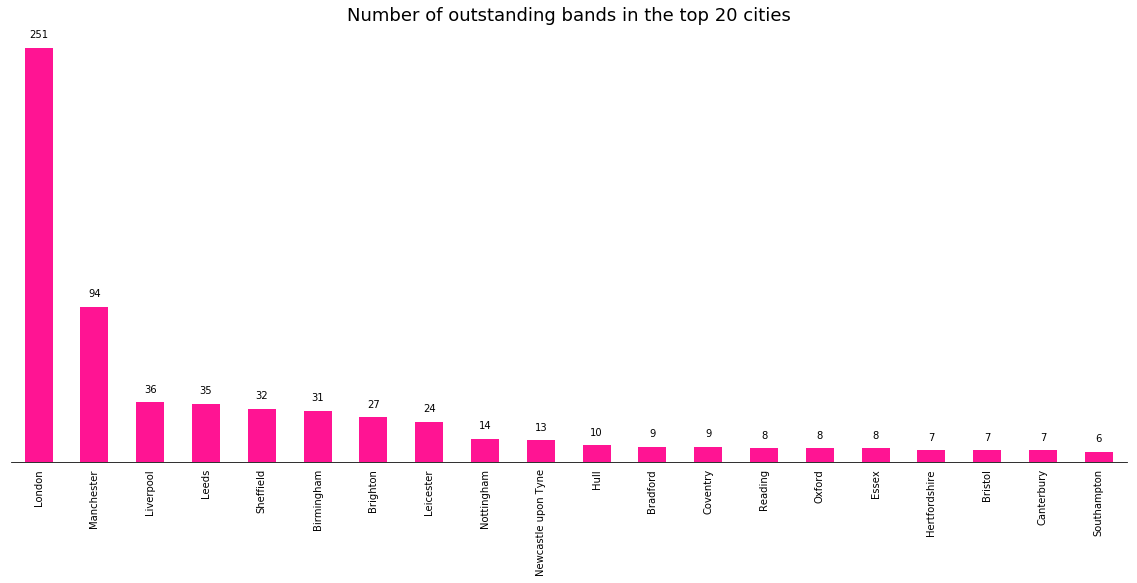

In [122]:
count_bands.head(20).plot(kind='bar',figsize=(20,8),color='deeppink')
plt.title('Number of outstanding bands in the top 20 cities',fontsize=18)
plt.legend().set_visible(False)
plt.xlabel('')
for x,y in zip(range(20),count_bands['Band'].head(20)):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') 
plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
plt.show()

### b) Top styles produced by city

From bands dataframe, the frequency of every style in each city is obtained. 

In [102]:
cit_gen=bands_df.groupby('City').sum().reindex(count_bands.index)
cit_gen.head(10)

,ROCK 'N' ROLL,GOLDEN AGE / CLASSIC ROCK,HEAVY METAL,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,ALTERNATIVE ROCK / INDIE,HARDCORE PUNK,CONTEMPORARY ROCK,POP MUSIC
City,,,,,,,,,
London,14,74,21,85,8,109,10,24,81
Manchester,2,18,1,31,3,57,2,8,28
Liverpool,2,6,3,11,1,18,1,4,15
Leeds,0,3,1,11,5,26,5,4,10
Sheffield,7,7,2,9,1,18,2,4,9
Birmingham,0,10,6,11,3,7,4,1,7
Brighton,2,5,0,3,0,16,4,7,5
Leicester,1,9,1,4,0,13,1,1,3
Nottingham,0,3,6,1,1,7,4,1,2


To better visualize the top styles produced in each city, the style participation percentage is calculated and coloured according to its value.

In [103]:
cit_gen_top=cit_gen.div(cit_gen.sum(axis=1), axis=0)
cit_gen_top=cit_gen_top.head(20).style.format('{:.2%}').background_gradient(cmap='RdPu',axis=1)
cit_gen_top

,ROCK 'N' ROLL,GOLDEN AGE / CLASSIC ROCK,HEAVY METAL,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,ALTERNATIVE ROCK / INDIE,HARDCORE PUNK,CONTEMPORARY ROCK,POP MUSIC
City,,,,,,,,,
London,3.29%,17.37%,4.93%,19.95%,1.88%,25.59%,2.35%,5.63%,19.01%
Manchester,1.33%,12.00%,0.67%,20.67%,2.00%,38.00%,1.33%,5.33%,18.67%
Liverpool,3.28%,9.84%,4.92%,18.03%,1.64%,29.51%,1.64%,6.56%,24.59%
Leeds,0.00%,4.62%,1.54%,16.92%,7.69%,40.00%,7.69%,6.15%,15.38%
Sheffield,11.86%,11.86%,3.39%,15.25%,1.69%,30.51%,3.39%,6.78%,15.25%
Birmingham,0.00%,20.41%,12.24%,22.45%,6.12%,14.29%,8.16%,2.04%,14.29%
Brighton,4.76%,11.90%,0.00%,7.14%,0.00%,38.10%,9.52%,16.67%,11.90%
Leicester,3.03%,27.27%,3.03%,12.12%,0.00%,39.39%,3.03%,3.03%,9.09%
Nottingham,0.00%,12.00%,24.00%,4.00%,4.00%,28.00%,16.00%,4.00%,8.00%


As it's shown in the dataframe above, the 'ALTERNATIVE ROCK / INDIE' style is the most produced for the majority of cities.

### c) Cities where the style is most produced in

Similarly, the percentage participation of every city in a style production is found.

In [104]:
cit_gen_top_in=cit_gen.div(cit_gen.sum(axis=0), axis=1)
cit_gen_top_in=cit_gen_top_in.head(20).style.format('{:.2%}').background_gradient(cmap='RdPu',axis=0)
cit_gen_top_in

,ROCK 'N' ROLL,GOLDEN AGE / CLASSIC ROCK,HEAVY METAL,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,ALTERNATIVE ROCK / INDIE,HARDCORE PUNK,CONTEMPORARY ROCK,POP MUSIC
City,,,,,,,,,
London,33.33%,34.10%,25.93%,35.71%,21.05%,28.09%,15.87%,30.77%,34.32%
Manchester,4.76%,8.29%,1.23%,13.03%,7.89%,14.69%,3.17%,10.26%,11.86%
Liverpool,4.76%,2.76%,3.70%,4.62%,2.63%,4.64%,1.59%,5.13%,6.36%
Leeds,0.00%,1.38%,1.23%,4.62%,13.16%,6.70%,7.94%,5.13%,4.24%
Sheffield,16.67%,3.23%,2.47%,3.78%,2.63%,4.64%,3.17%,5.13%,3.81%
Birmingham,0.00%,4.61%,7.41%,4.62%,7.89%,1.80%,6.35%,1.28%,2.97%
Brighton,4.76%,2.30%,0.00%,1.26%,0.00%,4.12%,6.35%,8.97%,2.12%
Leicester,2.38%,4.15%,1.23%,1.68%,0.00%,3.35%,1.59%,1.28%,1.27%
Nottingham,0.00%,1.38%,7.41%,0.42%,2.63%,1.80%,6.35%,1.28%,0.85%


London is the city that outstands in production for every style. This was expected as London is by far, the most populated city in England. 

## 4.2. Analyzing musical production density

In the analysis above, London outstanded in musical production mainly because of its population. In this section, population is taken into account to analyse how intense in terms of density is the musical production in the top city.

The data about population is obtained and added to the dataframe of frequency of cities.

In [105]:
pop_df = pd.read_csv(r'data.csv')

In [106]:
pop_df.head()

,asciiname,population,location
0,London,7556900,"https://www.google.com/maps/?q=51.50853,-0.12574"
1,Birmingham,984333,"https://www.google.com/maps/?q=52.48142,-1.89983"
2,Liverpool,864122,"https://www.google.com/maps/?q=53.41058,-2.97794"
3,Nottingham,729977,"https://www.google.com/maps/?q=52.9536,-1.15047"
4,Sheffield,685368,"https://www.google.com/maps/?q=53.38297,-1.4659"


In [107]:
cit_gen_dens=cit_gen.head(20)

In [108]:
for cit in cit_gen_dens.index.tolist():
    try:
        cit_gen_dens.loc[cit,'Population']=pop_df.loc[int(pop_df[pop_df['asciiname']==cit].index.values)]['population']
    except:
        cit_gen_dens.loc[cit,'Population']==np.nan

/Users/mamakino/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/mamakino/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [109]:
cit_gen_dens = cit_gen_dens[pd.notnull(cit_gen_dens['Population'])]

Every style column is divided by the population column to obtain the musical production by every 100,000 habitants.

In [110]:
cit_gen_dens.loc[:,'ALTERNATIVE ROCK / INDIE']=cit_gen_dens['ALTERNATIVE ROCK / INDIE'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'CONTEMPORARY ROCK']=cit_gen_dens['CONTEMPORARY ROCK'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'GOLDEN AGE / CLASSIC ROCK']=cit_gen_dens['GOLDEN AGE / CLASSIC ROCK'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'HARDCORE PUNK']=cit_gen_dens['HARDCORE PUNK'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'HEAVY METAL']=cit_gen_dens['HEAVY METAL'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'INDUSTRIAL & GOTHIC']=cit_gen_dens['INDUSTRIAL & GOTHIC'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'PUNK ROCK / NEW WAVE']=cit_gen_dens['PUNK ROCK / NEW WAVE'].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,"ROCK 'N' ROLL"]=cit_gen_dens["ROCK 'N' ROLL"].div(cit_gen_dens.Population, axis=0)*100000
cit_gen_dens.loc[:,'POP MUSIC']=cit_gen_dens['POP MUSIC'].div(cit_gen_dens.Population, axis=0)*100000

In [111]:
cit_gen_dens=cit_gen_dens.drop('Population',axis=1)

In [112]:
cit_gen_dens.style.format('{:,.1f}').background_gradient(cmap='RdPu',axis=0)

,ROCK 'N' ROLL,GOLDEN AGE / CLASSIC ROCK,HEAVY METAL,PUNK ROCK / NEW WAVE,INDUSTRIAL & GOTHIC,ALTERNATIVE ROCK / INDIE,HARDCORE PUNK,CONTEMPORARY ROCK,POP MUSIC
City,,,,,,,,,
London,0.2,1.0,0.3,1.1,0.1,1.4,0.1,0.3,1.1
Manchester,0.5,4.6,0.3,7.8,0.8,14.4,0.5,2.0,7.1
Liverpool,0.2,0.7,0.3,1.3,0.1,2.1,0.1,0.5,1.7
Leeds,0.0,0.7,0.2,2.4,1.1,5.7,1.1,0.9,2.2
Sheffield,1.0,1.0,0.3,1.3,0.1,2.6,0.3,0.6,1.3
Birmingham,0.0,1.0,0.6,1.1,0.3,0.7,0.4,0.1,0.7
Brighton,1.4,3.6,0.0,2.2,0.0,11.5,2.9,5.0,3.6
Leicester,0.2,1.8,0.2,0.8,0.0,2.6,0.2,0.2,0.6
Nottingham,0.0,0.4,0.8,0.1,0.1,1.0,0.5,0.1,0.3


Now, it's seen that actually, Canterbury outstands in musical production of 'ROCK 'N ROLL' and 'GOLDEN AGE / CLASSIC ROCK', Newcastle upon Tyne in musical production of 'HEAVY METAL', Brighton in musical production of 'HARDCORE PUNK' and 'CONTEMPORARY ROCK', Leeds in musical production on 'INDUSTRIAL & GOTHIC'. Finally, Manchester outstands in production of 'PUNK ROCK / NEW WAVE', 'ALTERNATIVE ROCK / INDIE' and 'POP MUSIC'! 

From these results, we can infere the musical tastes in England. For 'PUNK ROCK / NEW WAVE' and 'ALTERNATIVE ROCK / INDIE', Manchester is the most productive, so it can be said that this is the city where these styles are the most prefered. 

For these reasons, it's concluded that Manchester is the best city to start a Bandeoke business aimed to people keen on 80s and 90s music, where PUNK ROCK, NEW WAVE, ALTERNATIVE ROCK and INDIE were very popular.

## 4.3. Analyzing clusters in Manchester

### a) Visualizing the clusters

In [113]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(areas_merged['Latitude'], areas_merged['Longitude'], areas_merged['Neighborhood'], areas_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### b) Analizing clusters in Manchester

In the areas exploration, venues searched for were all about music, so every cluster is characterized for having some kind of venues related music categories. But besides that, the grouping has somehow classified the degree of musical activity in the areas clustered.

This way, clusters 1, 2 and 5 are characterized for having areas with very little musical activity. In cluster 1, areas are focused on bar activities and in cluster 2 areas are focused on pubs activities. For cluster 5, the only area almost doesn't have music activity. These clusters seem to group areas with very low economic movement.

On the other hand, clusters 3 seems to encompasses areas with medium musical activity.. Also, these cluster seems to group areas with medium economic movement.

Finally, cluster 4 gathers areas with high and very diverse musical movement. Besides, it seems to have high economic movement and to be very popular. In fact, the city centre is in this cluster.

#### Cluster 1

In [114]:
areas_merged.loc[areas_merged['Cluster Labels'] == 1, areas_merged.columns[[0] + list(range(4, areas_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Chorlton Park (ward),Bar,,,,,,,,,
34,Harpurhey,Bar,Pub,,,,,,,,
49,Northenden,Bar,Pub,Sports Bar,,,,,,,
50,Northern Moor,Bar,,,,,,,,,
57,"Ringway, Manchester",Bar,Pub,Bistro,,,,,,,
65,"Whalley Range, Manchester",Bar,,,,,,,,,


#### Cluster 2

In [115]:
areas_merged.loc[areas_merged['Cluster Labels'] == 2, areas_merged.columns[[0] + list(range(4, areas_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Hey,Pub,,,,,,,,,
7,"Belle Vue, Manchester",Pub,,,,,,,,,
8,Benchill,Pub,,,,,,,,,
9,"Beswick, Manchester",Pub,,,,,,,,,
14,Burnage,Pub,,,,,,,,,
15,Burnage (ward),Pub,,,,,,,,,
24,"Clayton, Manchester",Pub,,,,,,,,,
26,Crumpsall,Pub,,,,,,,,,
29,"Glenbrook, Greater Manchester",Pub,,,,,,,,,
30,Gorton,Pub,,,,,,,,,


#### Cluster 3

In [116]:
areas_merged.loc[areas_merged['Cluster Labels'] == 3, areas_merged.columns[[0] + list(range(4, areas_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Ardwick,Brewery,Pub,Bar,Lounge,Concert Hall,,,,,
4,Ardwick Green,Brewery,Beer Bar,Bar,Pub,Lounge,Speakeasy,Concert Hall,Other Nightlife,,
36,Hulme,Brewery,Pub,Gay Bar,Music Store,,,,,,
39,Longsight,Gay Bar,,,,,,,,,
43,Moss Side,Pub,Brewery,Gay Bar,,,,,,,
44,"Moston, Manchester",Pub,Gay Bar,,,,,,,,


#### Cluster 4

In [117]:
areas_merged.loc[areas_merged['Cluster Labels'] == 4, areas_merged.columns[[0] + list(range(4, areas_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Ancoats,Bar,Cocktail Bar,Pub,Nightclub,Music Store,Wine Bar,Café,Gay Bar,Whisky Bar,Concert Hall
5,Baguley,Pub,Bar,,,,,,,,
6,Barlow Moor,Pub,Bar,,,,,,,,
10,Blackley,Pub,Bar,,,,,,,,
11,Bradford-with-Beswick,Pub,Bar,Music Venue,Nightclub,,,,,,
12,"Bradford, Manchester",Pub,Lounge,Bar,Sake Bar,,,,,,
13,Brooklands (Manchester ward),Pub,Hotel,Bar,,,,,,,
16,Castlefield,Bar,Pub,Nightclub,Cocktail Bar,Wine Bar,Lounge,Gastropub,English Restaurant,Comedy Club,Mini Golf
17,"Cheetham, Manchester",Strip Club,Concert Hall,Other Nightlife,,,,,,,
18,Chorlton (ward),Bar,Pub,Cocktail Bar,Music Venue,Café,Other Nightlife,Restaurant,Pie Shop,Lounge,Beer Bar


#### Cluster 5

In [119]:
areas_merged.loc[areas_merged['Cluster Labels'] == 5, areas_merged.columns[[0] + list(range(4, areas_merged.shape[1]))]]

,Neighborhood,1th Most Common Venue,2th Most Common Venue,3th Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
25,Collyhurst,Hotel Bar,,,,,,,,,


# 5. Discussion <a name="discuss"></a>

In this project, in the absence of better information, the musical tastes in England cities have been derived from their musical style production. This could be misleading, as it's a lot much easier to create songs that rarely exceed two minutes (some varieties of punk) than to create really musical masterpieces (some musical pieces of progressive rock). But virtuosity and complexity rejection is something that also must be taken into account. Some people just prefer easy-listening music, otherwise, classical music would be the popular one. For these reasons, despite some pitfalls, it can be considered that musical production is a good indicator of musical preferences, and in this sense, Manchester most prefers punk, new wave, alternative and indie rock. 

On the other hand, from clusters analysis, the best areas to start the Bandeoke are those included in cluster 4. This cluster contains areas highly intense in musical movement, areas that also would be appealing for easy to singing music enthusiasts.

# 6. Conclusion <a name="conclusion"></a>

Despite having found London has produced the majority of outstanding bands for every style in England, if we take the population into account, Manchester is the most productive in punk rock, new wave alternative rock, indie rock and even pop music. About this, the best Manchester areas to set the Bandeoke business are in cluster 4.